<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>LGBMRegressor</a></span></li><li><span><a href="#SGDRegressor" data-toc-modified-id="SGDRegressor-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>SGDRegressor</a></span></li><li><span><a href="#RandomForestRegressor" data-toc-modified-id="RandomForestRegressor-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>RandomForestRegressor</a></span></li><li><span><a href="#GradientBoostingRegressor" data-toc-modified-id="GradientBoostingRegressor-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>GradientBoostingRegressor</a></span></li></ul></li><li><span><a href="#Обучение-и-тестирование" data-toc-modified-id="Обучение-и-тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение и тестирование</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

#  Прогнозирование заказов такси

Нам предоставлены данные о заказах такси в аэропортах. 

В нашей работе необходимо построить модель для прогнозирования количества заказов на следующий час, для привлечения достаточного количества водителей в период пиковой нагрузки.

План исследования:

1. Изучить доступные нам данные
2. Выполнить их подготовку для моделей
3. Обучить разные модели с подбором гиперпараметрами и выбрать лучшую
4. Проверить модель тестовой выборке и сделать выводы

## Подготовка данных

In [1]:
# загрузим библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import confusion_matrix, make_scorer, mean_squared_error, SCORERS
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor

from IPython.core.pylabtools import figsize

<div class="alert alert-block alert-success">
<b>Успех:</b> Отлично, что все импорты собраны в первой ячейке ноутбука! Если у того, кто будет запускать твой ноутбук будут отсутствовать некоторые библиотеки, то он это увидит сразу, а не в процессе!
</div>

Рассмотрим даннные

In [2]:
data = pd.read_csv('taxi.csv', parse_dates=[0])

In [3]:
display(data.head(3))
display(data.describe())
data.info()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [4]:
#в качестве индекса поставим первую колонку таблицы с данными о дате
data.set_index(data.columns[0], inplace=True)

Нам предоставлена информация по количеству заказов такси каждые 10 минут. Уеньшим количество обьектов наших данных,объеденив количество заказов за каждый час. 

In [5]:
#сгруппируем и агрегируем значения за каждый час
data = data.resample('1H').sum()

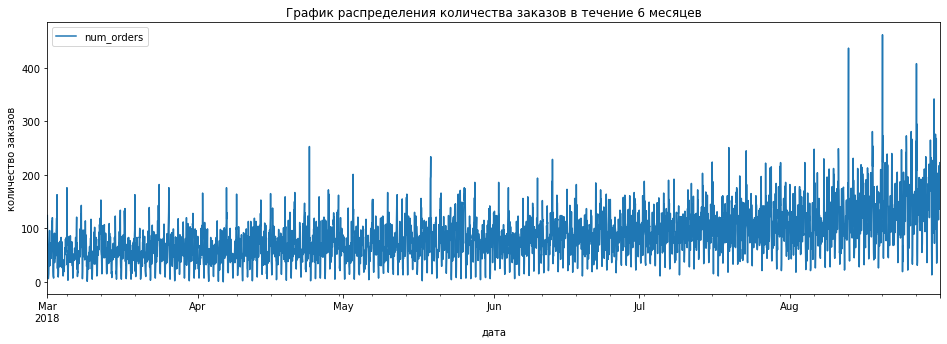

In [6]:
#визуализируем количество заказов такси в течение доступных нам данных
figsize(16,5)
data.plot()
plt.xlabel('дата')
plt.ylabel('количество заказов')
plt.title('График распределения количества заказов в течение 6 месяцев')
plt.show()

Рассмотрим тренд (плавное изменение среднего значения ряда) и его сезонность (т.е.цикличность этих изменений) для доступных нам данных

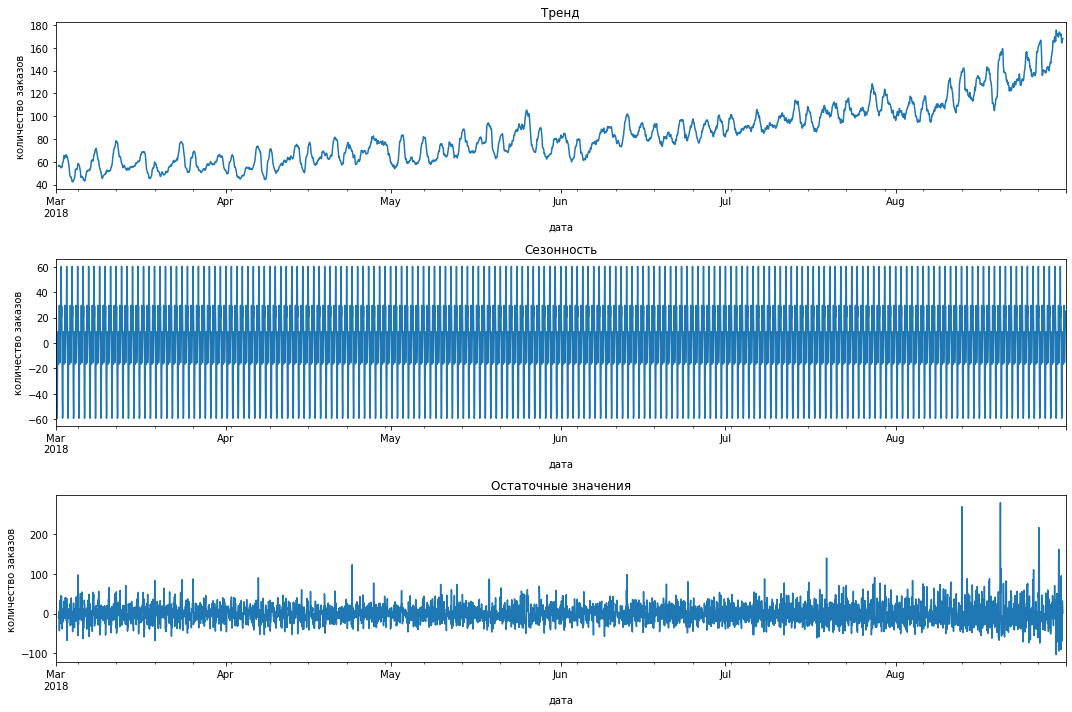

In [7]:
decomposed = seasonal_decompose(data) 

plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаточные значения')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.tight_layout()

Можно видеть наличие тренда: учеличение количества заказов в течение доступных нам данных: с марта до конца августа. Рассмотреть наличие или отсутсвие сезонности такого тренда у нас нет возможности, поскольку нам предоставлены данные лишь за один год.

Тогда рассмотрим количество изменений заказов в рамках одного дня

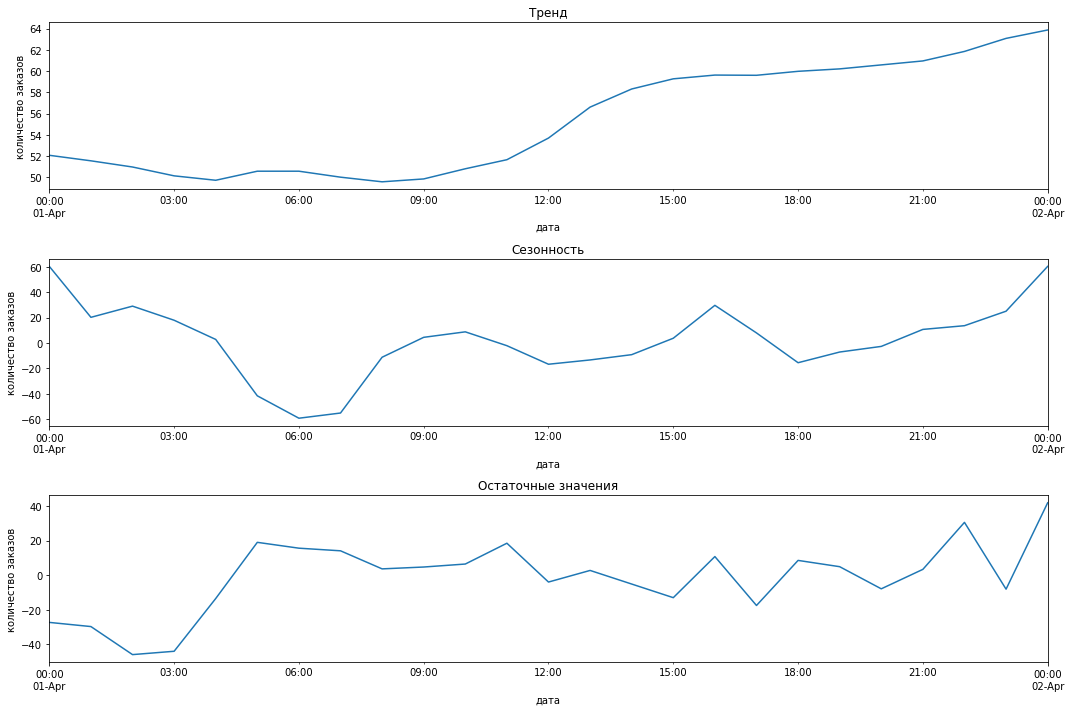

In [8]:
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend['2018-04-01 00:00:00':'2018-04-02 00:00:00'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.subplot(312)
decomposed.seasonal['2018-04-01 00:00:00':'2018-04-02 00:00:00'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.subplot(313)
decomposed.resid['2018-04-01 00:00:00':'2018-04-02 00:00:00'].plot(ax=plt.gca())
plt.title('Остаточные значения')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.tight_layout()

Мы чётко видим увеличение количества заказов к вечеру. Однако по данным за один день, нет возможности сделать вывод о сезонности таких изменений. 

Чтобы увидеть сезонность рассмотрим данные за четыре дня.

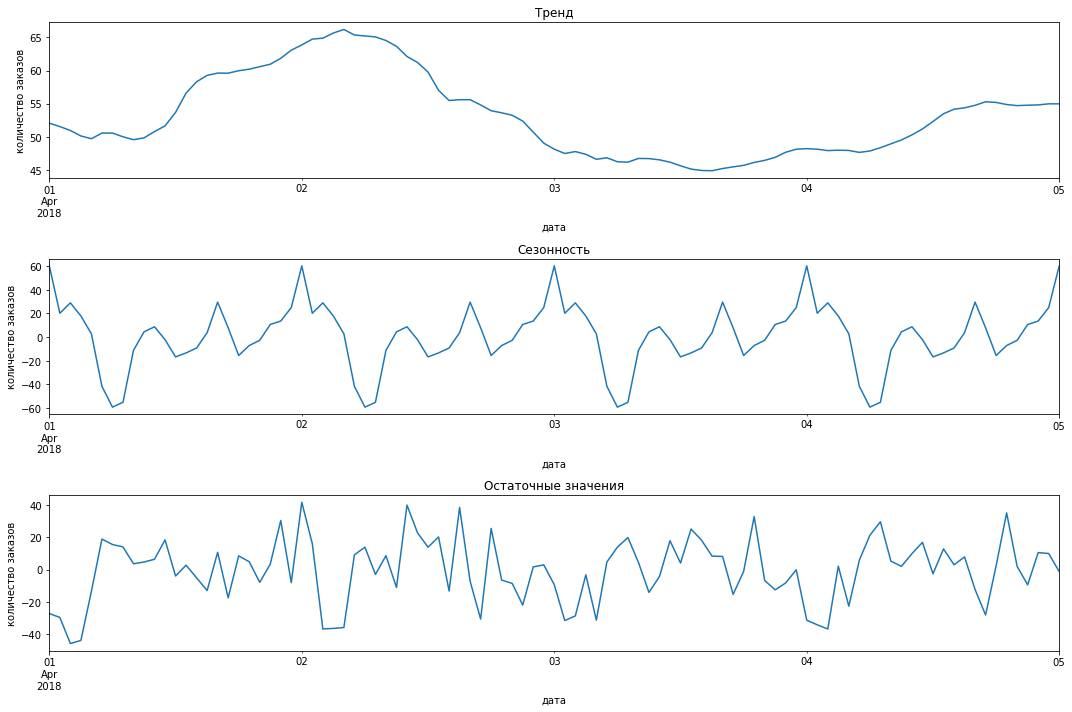

In [9]:
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend['2018-04-01 00:00:00':'2018-04-05 00:00:00'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.subplot(312)
decomposed.seasonal['2018-04-01 00:00:00':'2018-04-05 00:00:00'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.subplot(313)
decomposed.resid['2018-04-01 00:00:00':'2018-04-05 00:00:00'].plot(ax=plt.gca())
plt.title('Остаточные значения')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.tight_layout()

Так же рассмотрим данные за неделю. 13 августа 2018 года, был понедельник. Рассмотрим данные с этой даны, до следующего понедельника. Интересно, заказывают ли такси больше в выходные? На этот вопрос сможет ответить график тренда.

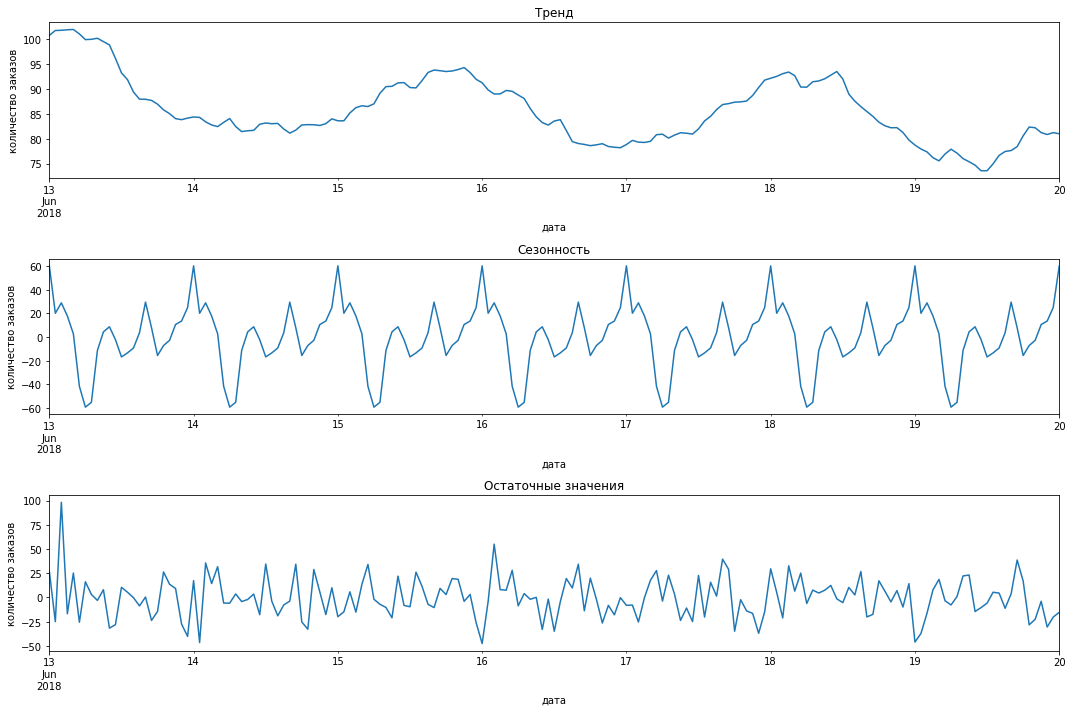

In [10]:
plt.figure(figsize=(15, 10))

plt.subplot(311)
decomposed.trend['2018-06-13 00:00:00':'2018-06-20 00:00:00'].plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.subplot(312)
decomposed.seasonal['2018-06-13 00:00:00':'2018-06-20 00:00:00'].plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.subplot(313)
decomposed.resid['2018-06-13 00:00:00':'2018-06-20 00:00:00'].plot(ax=plt.gca())
plt.title('Остаточные значения')
plt.xlabel('дата')
plt.ylabel('количество заказов')

plt.tight_layout()

Рассматривая графики за три дня и неделю, мы совершенно точно наблюдаем сезонность заждый день: минимум заказов в 6 часов утра, локальные максимумы в 10 и 16 часов, и абсолютный максимум в полночь. 
Рассматривая тренд в течение недели, мы не можем сделать категоричных выводов. Однако наблюдаются локальные максимумы заказов утром и днём в понедельник, вечером в среду, и в ночь с пятницы на субботу.

## Анализ

Чтобы как можно лучге предсказывать количество заказов такси, попробуем обучить четыре модели регрессии, которые нам в этом могут помочь: LGBMRegressor, SGDRegressor, RandomForestRegressor и GradientBoostingRegressor.

При этом будем подбирать оптимальные отстающие значения и скользящее среднее, а также для каждой их комбинации, подбирём гиперпараметры модели.

### LGBMRegressor

Для всех тестируемых под нашу задачу моделей, создадим функцию, которая создаёт дополнительные признаки. Дополнительные признаки будем делать из колонки о времени и дате. Таким образом у нас появятся такие признаки, как месяц, день, день недели и время дня. 

Также, в функции будет присутсвовать создание признаков со сдвигом данных вдоль по временной оси на разное количество шагов вперёд. Предыдущие значения временного ряда подскажут, будет ли значения в течение времени расти или уменьшаться. Оптимальный сдвиг по времени, для успешного прогнозирования, будем подбирать опытным путём ниже.

Далее, мы будем создавать дополнительные признаки, добавляя скользящее среднее. При этом, мы задаём количество временных шагов, попадающее в отрезок, и вычисляем их среднее арифметическое значение в этом промежутке времени. Скользящее среднее как признак показывает нам общий тренд временного ряда. При этом для каждого момента времени, исключается из отрезка для скользящего среднего текущее значение ряда. Потому что в противном случае, целевой признак (текущее значение) будет присутствовать в признаках, на которых обучается модель. Оптимальное количество шагов, попадающее в отрезок для скользящего среднего, также будем подбирать.

При этом, начальные данные мы не будем изменять, и новые признаки будем добавлять в копию данных. 

В качестве метрики для оценки модели будем использовать корень из среднеквадратичной ошибки между прогнозируемыми и фактическими значениями: RMSE.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    data_copy = data.copy()
    data_copy['month'] = data_copy.index.month
    data_copy['day'] = data_copy.index.day
    data_copy['dayofweek'] = data_copy.index.dayofweek
    data_copy['hour'] = data_copy.index.hour
    
    for lag in range(1, max_lag + 1):
        data_copy['lag_{}'.format(lag)] = data_copy['num_orders'].shift(lag)

    data_copy['rolling_mean'] = data_copy['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return data_copy

При делении  данных на обучающую и тестовую выборку, нам нужно оставить временной порядок данных, и не смешивать предыдущие и последующие по времени данные. Поэтому при делении на выборки установим параметр shuffle=False. 
Из-за этой же причины - чтобы избежать перетасовки данных при кросвалидации при подборе гиперпараметров, мы будем использовать TimeSeriesSplit

In [12]:
%%time

max_lag_range = [2, 10, 20]
rolling_mean_range = [2,10,20]

results_lgbmr={}

params_lgbmr = {'n_estimators': [1000, 5000],
               'learning_rate': [0.01, 0.3],
               'num_leaves': [20, 100],
               'max_depth': [3, 12, 20]}
   
for max_lag in max_lag_range:
    for rolling_mean_size in rolling_mean_range:
        data_copy = make_features(data, max_lag=max_lag, rolling_mean_size=rolling_mean_size)

        train, test = train_test_split(data_copy, shuffle=False, test_size=0.1)

        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']
        features_test = test.drop('num_orders', axis=1)
        target_test = test['num_orders']
        
        train = train.dropna() 
        test = test.dropna()
        
        tscv = TimeSeriesSplit(n_splits=5)
        
        lgbmr = LGBMRegressor(random_state = 10)
                
        gs = GridSearchCV(lgbmr, param_grid=params_lgbmr, scoring='neg_root_mean_squared_error',\
                          n_jobs=-1,cv=tscv, verbose=True)

        gs.fit(features_train, target_train)

        results_lgbmr[(max_lag, rolling_mean_size)] = {'learning_rate': gs.best_params_['learning_rate'],\
                                                 'max_depth': gs.best_params_['max_depth'],\
                                                 'n_estimators': gs.best_params_['n_estimators'],\
                                                 'num_leaves': gs.best_params_['num_leaves'],\
                                                 'rmse': gs.best_score_}

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 24 candidates, totalling 120 fits
CPU times: user 2min 46s, sys: 1.72 s, total: 2min 48s
Wall time: 23min 7s


In [14]:
results_lgbmr_df = pd.DataFrame(results_lgbmr)
results_lgbmr_df = results_lgbmr_df.round(2)
display(results_lgbmr_df)

2                          10                         20  \
                    2        10       20       2        10       20       2    
learning_rate     0.01     0.01     0.01     0.01     0.01     0.01     0.01   
max_depth        12.00    12.00    20.00    12.00    12.00    20.00    12.00   
n_estimators   1000.00  1000.00  1000.00  1000.00  1000.00  1000.00  1000.00   
num_leaves       20.00    20.00    20.00    20.00    20.00    20.00   100.00   
rmse            -25.60   -25.12   -24.98   -24.86   -24.98   -24.95   -24.83   

                                 
                    10       20  
learning_rate     0.01     0.01  
max_depth        12.00    12.00  
n_estimators   1000.00  1000.00  
num_leaves      100.00   100.00  
rmse            -24.89   -24.90

In [19]:
# чтобы таблица с результатами была более информативна, изменим названия колонок
new_names = {
    ('2', '2'): 'max_lag 2 & rolling_mean 2',
    ('2', '10'): 'max_lag 2 & rolling_mean 10',
    ('2', '20'): 'max_lag 2 & rolling_mean 20',
    ('10', '2'): 'max_lag 10 & rolling_mean 2',
    ('10', '10'): 'max_lag 10 & rolling_mean 10',
    ('10', '20'): 'max_lag 10 & rolling_mean 220',
    ('20', '2'): 'max_lag 20 & rolling_mean 2',
    ('20', '10'): 'max_lag 20 & rolling_mean 10',
    ('20', '20'): 'max_lag 20 & rolling_mean 220',
}

In [21]:
results_lgbmr_df.columns = new_names.values()
display(results_lgbmr_df)

,max_lag 2 & rolling_mean 2,max_lag 2 & rolling_mean 10,max_lag 2 & rolling_mean 20,max_lag 10 & rolling_mean 2,max_lag 10 & rolling_mean 10,max_lag 10 & rolling_mean 220,max_lag 20 & rolling_mean 2,max_lag 20 & rolling_mean 10,max_lag 20 & rolling_mean 220
learning_rate,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
max_depth,12.00,12.00,20.00,12.00,12.00,20.00,12.00,12.00,12.00
n_estimators,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
num_leaves,20.00,20.00,20.00,20.00,20.00,20.00,100.00,100.00,100.00
rmse,-25.60,-25.12,-24.98,-24.86,-24.98,-24.95,-24.83,-24.89,-24.90


### SGDRegressor

In [22]:
%%time

results_sgdr = {}

params_sgdr = {'learning_rate': ['constant', 'invscaling', 'adaptive'],
               'eta0': [0.01, 0.1, 1.0],
               'max_iter':[1000, 5000]}

for max_lag in max_lag_range:
    for rolling_mean_size in rolling_mean_range:
        data_copy = make_features(data, max_lag=max_lag, rolling_mean_size=rolling_mean_size)

        train, test = train_test_split(data_copy, shuffle=False, test_size=0.1)
        train = train.dropna() 
        test = test.dropna()

        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']
        features_test = test.drop('num_orders', axis=1)
        target_test = test['num_orders']
        
        tscv = TimeSeriesSplit(n_splits=5)
        
        sgdr = SGDRegressor(random_state = 10)
                
        gs_sgdr = GridSearchCV(sgdr, param_grid=params_sgdr, scoring='neg_root_mean_squared_error',\
                               n_jobs=-1,cv=tscv, verbose=True)

        gs_sgdr.fit(features_train, target_train)

        results_sgdr[(max_lag, rolling_mean_size)] = {'learning_rate': gs_sgdr.best_params_['learning_rate'],\
                                                      'eta0' : gs_sgdr.best_params_['eta0'],\
                                                      'max_iter': gs_sgdr.best_params_['max_iter'],\
                                                      'rmse':  gs_sgdr.best_score_}

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
CPU times: user 2.62 s, sys: 198 ms, total: 2.82 s
Wall time: 9.29 s


In [33]:
results_sgdr_df = pd.DataFrame(results_sgdr)
results_sgdr_df = results_sgdr_df.round(2)
results_sgdr_df.columns = new_names.values()
display(results_sgdr_df)

,max_lag 2 & rolling_mean 2,max_lag 2 & rolling_mean 10,max_lag 2 & rolling_mean 20,max_lag 10 & rolling_mean 2,max_lag 10 & rolling_mean 10,max_lag 10 & rolling_mean 220,max_lag 20 & rolling_mean 2,max_lag 20 & rolling_mean 10,max_lag 20 & rolling_mean 220
learning_rate,adaptive,adaptive,adaptive,adaptive,adaptive,adaptive,adaptive,adaptive,adaptive
eta0,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
max_iter,1000,1000,1000,1000,1000,1000,1000,1000,1000
rmse,-46012168792.651199,-61676644294.970657,-58510150363.764725,-82164416381.919052,-60279566735.317886,-70257896775.136536,-103300660766.921249,-153456886722.982574,-229515033507.689056


### RandomForestRegressor

In [24]:
%%time

results_rf = {}

params_rf = {'n_estimators': [250, 500],
             'max_depth': [15, 30]}

for max_lag in max_lag_range:
    for rolling_mean_size in rolling_mean_range:
        data_copy = make_features(data, max_lag=max_lag, rolling_mean_size=rolling_mean_size)

        train, test = train_test_split(data_copy, shuffle=False, test_size=0.1)
        train = train.dropna() 
        test = test.dropna()

        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']
        features_test = test.drop('num_orders', axis=1)
        target_test = test['num_orders']
        
        tscv = TimeSeriesSplit(n_splits=5)
        
        rf = RandomForestRegressor(random_state = 10)
                
        gs_rf = GridSearchCV(rf, param_grid=params_rf, scoring='neg_root_mean_squared_error',\
                             n_jobs=-1,cv=tscv, verbose=True)

        gs_rf.fit(features_train, target_train)

        results_rf[(max_lag, rolling_mean_size)] = {'n_estimators': gs_rf.best_params_['n_estimators'],\
                                                      'max_depth' : gs_rf.best_params_['max_depth'],\
                                                      'rmse': gs_rf.best_score_}

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
CPU times: user 1min 45s, sys: 150 ms, total: 1min 46s
Wall time: 6min 14s


In [34]:
results_rf_df = pd.DataFrame(results_rf)
results_rf_df = results_rf_df.round(2)
results_rf_df.columns = new_names.values()
display(results_rf_df)

,max_lag 2 & rolling_mean 2,max_lag 2 & rolling_mean 10,max_lag 2 & rolling_mean 20,max_lag 10 & rolling_mean 2,max_lag 10 & rolling_mean 10,max_lag 10 & rolling_mean 220,max_lag 20 & rolling_mean 2,max_lag 20 & rolling_mean 10,max_lag 20 & rolling_mean 220
n_estimators,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
max_depth,15.00,15.00,30.00,30.00,30.00,30.00,30.00,30.00,30.00
rmse,-25.59,-25.09,-25.07,-25.16,-25.12,-25.13,-25.23,-25.11,-25.14


### GradientBoostingRegressor

In [26]:
%%time

results_gb = {}

params_gb={'n_estimators':[500, 1000],
           'learning_rate':[0.01,.1],
           'max_depth':[1,2,4],
           }
for max_lag in max_lag_range:
    for rolling_mean_size in rolling_mean_range:
        data_copy = make_features(data, max_lag=max_lag, rolling_mean_size=rolling_mean_size)

        train, test = train_test_split(data_copy, shuffle=False, test_size=0.1)
        train = train.dropna() 
        test = test.dropna()

        features_train = train.drop('num_orders', axis=1)
        target_train = train['num_orders']
        features_test = test.drop('num_orders', axis=1)
        target_test = test['num_orders']
        
        tscv = TimeSeriesSplit(n_splits=5)
        
        gb=GradientBoostingRegressor(random_state = 10)
                
        gs_gb = GridSearchCV(gb, param_grid=params_gb, scoring='neg_root_mean_squared_error',\
                               n_jobs=-1,cv=tscv, verbose=True)

        gs_gb.fit(features_train, target_train)

        results_gb[(max_lag, rolling_mean_size)] = {'n_estimators': gs_gb.best_params_['n_estimators'],\
                                                    'learning_rate' : gs_gb.best_params_['learning_rate'],\
                                                    'max_depth' : gs_gb.best_params_['max_depth'],\
                                                    'rmse': gs_gb.best_score_}

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
CPU times: user 1min 21s, sys: 144 ms, total: 1min 21s
Wall time: 7min 2s


In [35]:
results_gb_df = pd.DataFrame(results_gb)
results_gb_df = results_gb_df.round(2)
results_gb_df.columns = new_names.values()
display(results_gb_df)

,max_lag 2 & rolling_mean 2,max_lag 2 & rolling_mean 10,max_lag 2 & rolling_mean 20,max_lag 10 & rolling_mean 2,max_lag 10 & rolling_mean 10,max_lag 10 & rolling_mean 220,max_lag 20 & rolling_mean 2,max_lag 20 & rolling_mean 10,max_lag 20 & rolling_mean 220
n_estimators,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00,1000.00
learning_rate,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01
max_depth,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00
rmse,-25.63,-25.44,-25.29,-25.33,-25.49,-25.44,-25.41,-25.30,-25.34


## Обучение и тестирование

По значению метрики RMSE лучшие результаты показали модели LGBMRegressor и RandomForestRegressor. Однако время работы, намного меньше у второй модели. Её и будем использовать для тестовой выборки со всеми подобранными параметрами.

In [28]:
data_copy = make_features(data, max_lag=2, rolling_mean_size=20)

train, test = train_test_split(data_copy, shuffle=False, test_size=0.1)
train = train.dropna() 
test = test.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']
        
rf=RandomForestRegressor(random_state = 10, n_estimators = 500, max_depth = 30, n_jobs=-1)
                
rf.fit(features_train, target_train)

prediction_rf = rf.predict(features_test)

rmse_rf = np.sqrt(mean_squared_error(target_test, prediction_rf))

In [38]:
print(f'Лучшее значение метрики RMSE на наших данных {rmse_rf:.3f}')

Лучшее значение метрики RMSE на наших данных 46.191


Визуализируем результаты. Рассмотрим промежуток в 18 дней в августе. ПОсмотри на графике, как точно прогнозируемый результат совпадает с реальным количеством заказов.

In [39]:
start_date = '2018-08-13 14:00:00'
end_date = '2018-08-31 23:00:00'

index = pd.date_range(start=start_date, end=end_date, freq='H')

prediction_rf_s = pd.Series(prediction_rf, index=index)
display(prediction_rf_s.head(3))
display(target_test.head(3))

2018-08-13 14:00:00    106.742
2018-08-13 15:00:00    108.588
2018-08-13 16:00:00    142.294
Freq: H, dtype: float64

datetime
2018-08-13 14:00:00    102
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
Freq: H, Name: num_orders, dtype: int64

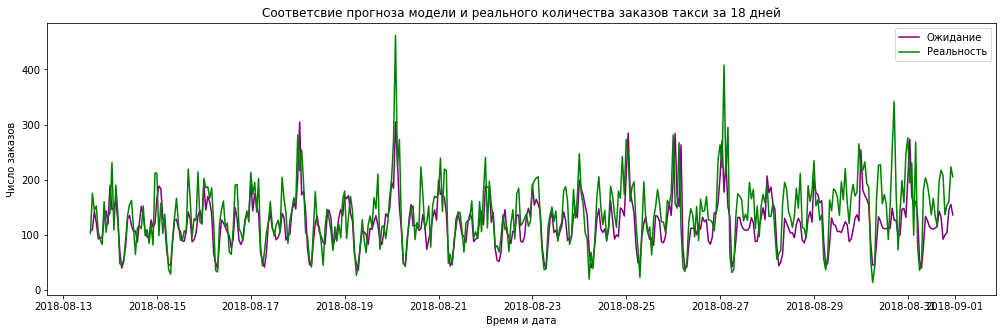

In [42]:
figsize(17,5)
plt.plot(prediction_rf_s, label = "Ожидание", color = 'purple')
plt.plot(target_test, label = "Реальность", color = 'green')
plt.legend()
plt.title('Соответсвие прогноза модели и реального количества заказов такси за 18 дней')
plt.xlabel("Время и дата")
plt.ylabel("Число заказов")
plt.show()

## Вывод

В нашей задаче нам необходимо было подготовить данные, создать новые признаки и подобрать лучшую модель для предсказания количества заказов такси на следующий час. Для этого нам предоставили данные о заказах такси за предыдущие 6 месяцев. 

Нам удалось достичь значения RMSE = 46.191, при использовании модели RandomForestRegressor при гиперпараметрах: n_estimators = 500,max_depth = 30 и значениях max_lag=2, rolling_mean_size=20. Значение RMSE измеряется в нашем случае в количестве заказов. Т.е. наша модель может ошибаться в любую сторону в среднем на 46 заказов каждый час, что особенно в часы пик, является небольшим значением. 

Поэтому можем сделать вывод, что подобранная модель, отвечает запросу и может отлично предсказывать количество заказов такси.